In [1]:
import pandas as pd
import ast
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import spacy
from itertools import chain
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 50)


In [2]:
# functions

def nation(textlist):
    """
    get information about recipe nationality
    """
    text = " ".join(textlist)
    processed = nlp(text)
    nationalities = list(set(i.text for i in processed.ents if i.label_ == "NORP"))
    return nationalities


def serving_size(original):
    """
    this leaves serving_size as int which is in grams
    """
    new = original[1:]
    match = re.findall(r"\d+", new)
    if match:
        return int(match[0])
    return None

<h1 style="color: #FFAA55;">Data</h1>
Create df merging Recipes_1 and Recipes_2  

### Recipes_1
with nutrition values  

### Recipes_2
for using recipes, with servings and ingredient quantity  

### Recipes_3
for nutrition values

In [3]:
df = pd.read_csv("./data/master.csv")

<h1 style="color: #FFAA55;">Cleaning</h1>


In [4]:
# import both datasets
df1 = pd.read_csv("./data/recipes_3.csv")
df2 = pd.read_csv("./data/recipes_2.csv")

In [5]:
# create merged df
df1.rename(columns={"RecipeId": "id"}, inplace=True)
df1.drop(columns=["AuthorId", "AuthorName"], inplace=True)
df = pd.merge(df2, df1, on="id", how="left")

In [6]:
# clean df
df.drop(columns=["name", "Description", "ReviewCount", "RecipeYield", "RecipeIngredientParts", "RecipeInstructions", "RecipeServings"], inplace=True)
df.columns = [columns.lower().replace(" ", "_") for columns in df.columns]

In [7]:
df["serving_size"] = df["serving_size"].apply(serving_size)

In [8]:
df["new_tags"] = df["tags"].apply(lambda x: ast.literal_eval(x))

In [9]:
# cleaning integer columns (time)

def times(x):
    if pd.notnull(x):
        y = x.replace("PT", "")
        return y
    return None

df["cooktime"] = df["cooktime"].apply(times)
df["preptime"] = df["preptime"].apply(times)
df["totaltime"] = df["totaltime"].apply(times)

<h1 style="color: #FFAA55;">Feature Engineering</h1>

In [ ]:
# takes some time
"""
# get information about the nationality of the recipe
nlp = spacy.load("en_core_web_sm")
df["nations"] = df["new_tags"].apply(nation)
"""

In [5]:
ast.literal_eval(df["nations"][2])

def convert_list(x):
    return ast.literal_eval(x)

df["nations"] = df["nations"].apply(convert_list)

In [7]:
df.to_csv("data/master.csv")

<h1 style="color: #FFAA55;">Statistics</h1>

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,494963.0,268932.473191,154558.312287,38.0,135085.5,267958.0,402274.5,537804.0
serving_size,494963.0,375.065344,2702.043601,0.0,122.0,219.0,381.0,1595816.0
servings,494963.0,7.063164,94.677417,1.0,4.0,4.0,8.0,32767.0
aggregatedrating,258307.0,4.629574,0.643114,1.0,4.5,5.0,5.0,5.0
calories,494949.0,487.296062,1417.104646,0.0,179.0,321.2,530.9,612854.6
fatcontent,494949.0,24.839080,113.142935,0.0,5.9,14.0,27.6,64368.1
saturatedfatcontent,494949.0,9.673535,46.877944,0.0,1.6,4.8,10.9,26740.6
cholesterolcontent,494949.0,88.349779,308.180545,0.0,5.5,45.5,110.0,130456.4
sodiumcontent,494949.0,740.142478,3535.812569,0.0,131.3,360.8,796.3,731056.4
carbohydratecontent,494949.0,49.123498,183.721345,0.0,13.1,28.6,51.3,108294.6


In [11]:
df.head()

,id,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,name,cooktime,preptime,totaltime,datepublished,images,recipecategory,keywords,recipeingredientquantities,aggregatedrating,calories,fatcontent,saturatedfatcontent,cholesterolcontent,sodiumcontent,carbohydratecontent,fibercontent,sugarcontent,proteincontent,new_tags
0,96313,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",155,8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...",Grilled Garlic Cheese Grits,PT50M,PT15M,PT1H5M,2004-07-24T20:00:00Z,"""https://img.sndimg.com/food/image/upload/w_55...",Grains,"c(""Cheese"", ""Low Cholesterol"", ""Brunch"", ""Refr...","c(""4"", ""1"", ""1"", ""4"", ""1 -2"", ""1"")",5.0,144.8,6.7,3.3,14.9,382.7,15.7,0.9,0.2,5.0,"[time-to-make, course, main-ingredient, prepar..."
1,232037,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",366,4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}",Simple Shrimp and Andouille Jambalaya,PT25M,PT20M,PT45M,2007-06-03T22:51:00Z,character(0),One Dish Meal,"c(""Pork"", ""Meat"", ""< 60 Mins"", ""Easy"")","c(""1"", ""1"", ""5"", ""1"", NA, NA, ""1"", ""3/4"", ""1 1...",5.0,756.5,28.9,9.0,191.8,2094.9,82.3,3.9,9.7,39.2,"[60-minutes-or-less, time-to-make, course, mai..."
2,41090,NaN,"['white beans', 'canned black beans', 'tomatoe...","[""1 cup canned white beans, rinsed and dra...",807,1,"['In a large bowl, combine beans, tomato, onio...","['15-minutes-or-less', 'time-to-make', 'course...","{'vegetarian', 'salad', 'side', 'dinner', 'veg...",black-and-white bean salad,NaN,PT5M,PT5M,2002-09-24T22:53:00Z,character(0),Black Beans,"c(""Beans"", ""Vegan"", ""Potluck"", ""Spring"", ""Summ...","c(""1"", ""1"", ""1"", ""1"", ""1"", ""1"", ""2"", ""1/8"", ""1...",4.5,159.0,1.6,0.3,0.0,318.3,28.3,8.3,2.1,9.1,"[15-minutes-or-less, time-to-make, course, mai..."
3,60656,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",244,4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}",Crock Pot Italian Zucchini,PT6H,PT10M,PT6H10M,2003-04-22T20:07:00Z,character(0),Vegetable,"c(""Winter"", ""Weeknight"", ""Beginner Cook"", ""Easy"")","c(""2"", ""2"", ""2 -3"", ""1"", ""4"", ""1"", ""2"", ""1"", NA)",4.0,47.1,0.4,0.1,0.0,19.1,10.4,2.7,4.6,2.6,"[weeknight, time-to-make, course, main-ingredi..."
4,232047,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",358,8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},Beef Stew With Dried Cherries,PT2H,PT45M,PT2H45M,2007-06-03T23:06:00Z,character(0),Stew,"c(""Meat"", ""< 4 Hours"", ""Easy"")","c(""3"", ""3"", ""1"", ""1/2"", ""1/2"", ""1/2"", ""1"", ""3""...",NaN,691.1,45.8,17.7,177.1,503.6,14.4,1.6,6.8,48.2,"[time-to-make, course, main-ingredient, prepar..."


<h1 style="color: #FFAA55;">Plots</h1>

In [12]:
df_plots = df.dropna(subset=["cooktime", "preptime", "totaltime", "datepublished", "recipeingredientquantities", "calories"])

/var/folders/4d/kvxdy8f57vb9008_7qx5gx780000gn/T/ipykernel_6985/3034113187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plots["calories_per_g"] = df_plots["calories"] / df_plots["serving_size"]


Text(0, 0.5, 'Number of Recipes')

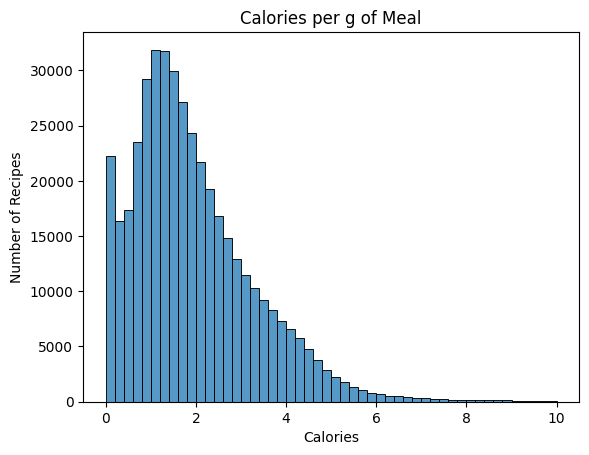

In [13]:
# plot calories per g
df_plots["calories_per_g"] = df_plots["calories"] / df_plots["serving_size"]
cal_plot = df_plots[df_plots["calories_per_g"] < 10]
sns.histplot(cal_plot["calories_per_g"], bins=50)

plt.title("Calories per g of Meal")
plt.xlabel("Calories")
plt.ylabel("Number of Recipes")

Text(0, 0.5, 'Number of Recipes')

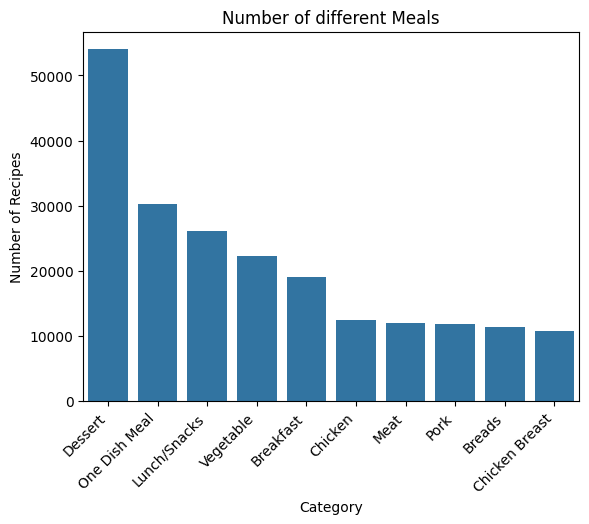

In [14]:
# numbers of different recipes
types = df_plots["recipecategory"].value_counts().head(10)

sns.barplot(types)
plt.title("Number of different Meals")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Number of Recipes")

Text(0, 0.5, 'Number of Recipes')

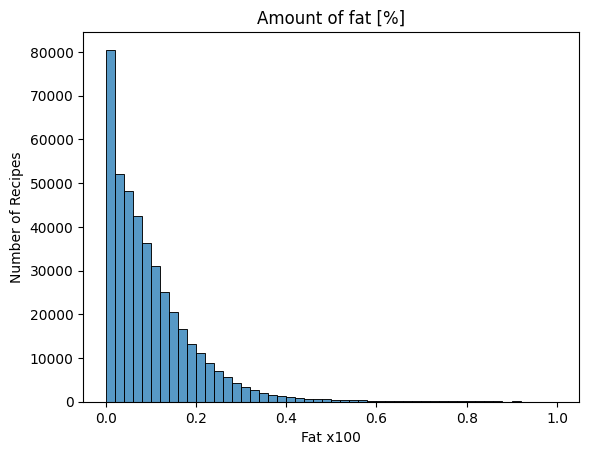

In [15]:
# fat per g serving
fat = (df_plots["fatcontent"] / df_plots["serving_size"])
filtered_fat = fat[fat < 1]
sns.histplot(filtered_fat, bins=50)

plt.title("Amount of fat [%]")
plt.xlabel("Fat x100")
plt.ylabel("Number of Recipes")

Text(0, 0.5, 'Number of Recipes')

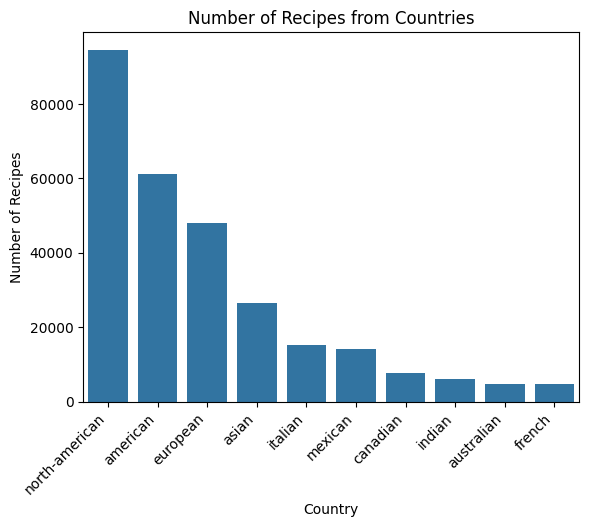

In [37]:
# plot nation information
nations_flat = list(chain.from_iterable(df["nations"]))
counts = pd.Series(nations_flat).value_counts().head(10)
sns.barplot(counts)

plt.title("Number of Recipes from Countries")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Number of Recipes")

<h1 style="color: #FFAA55;">Insights</h1>

In [16]:
search = "american"
searching = df[df["new_tags"].apply(lambda x: search in x)]